# Compare predictive performance across endpoint categories

How does predictive performance compare across endpoint types?

In [47]:
import polars as pl 
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import warnings

## Input annotations

In [23]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"../compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type")
)

pred_pandas = pred_df.to_pandas()
pred_pandas['Endpoint_type'] = pd.Categorical(
    pred_pandas['Endpoint_type'], 
    categories=["axiom_cytotox", "toxcast_cytotox", "toxcast_cellbased", "toxcast_cellfree"],
    ordered=True
)


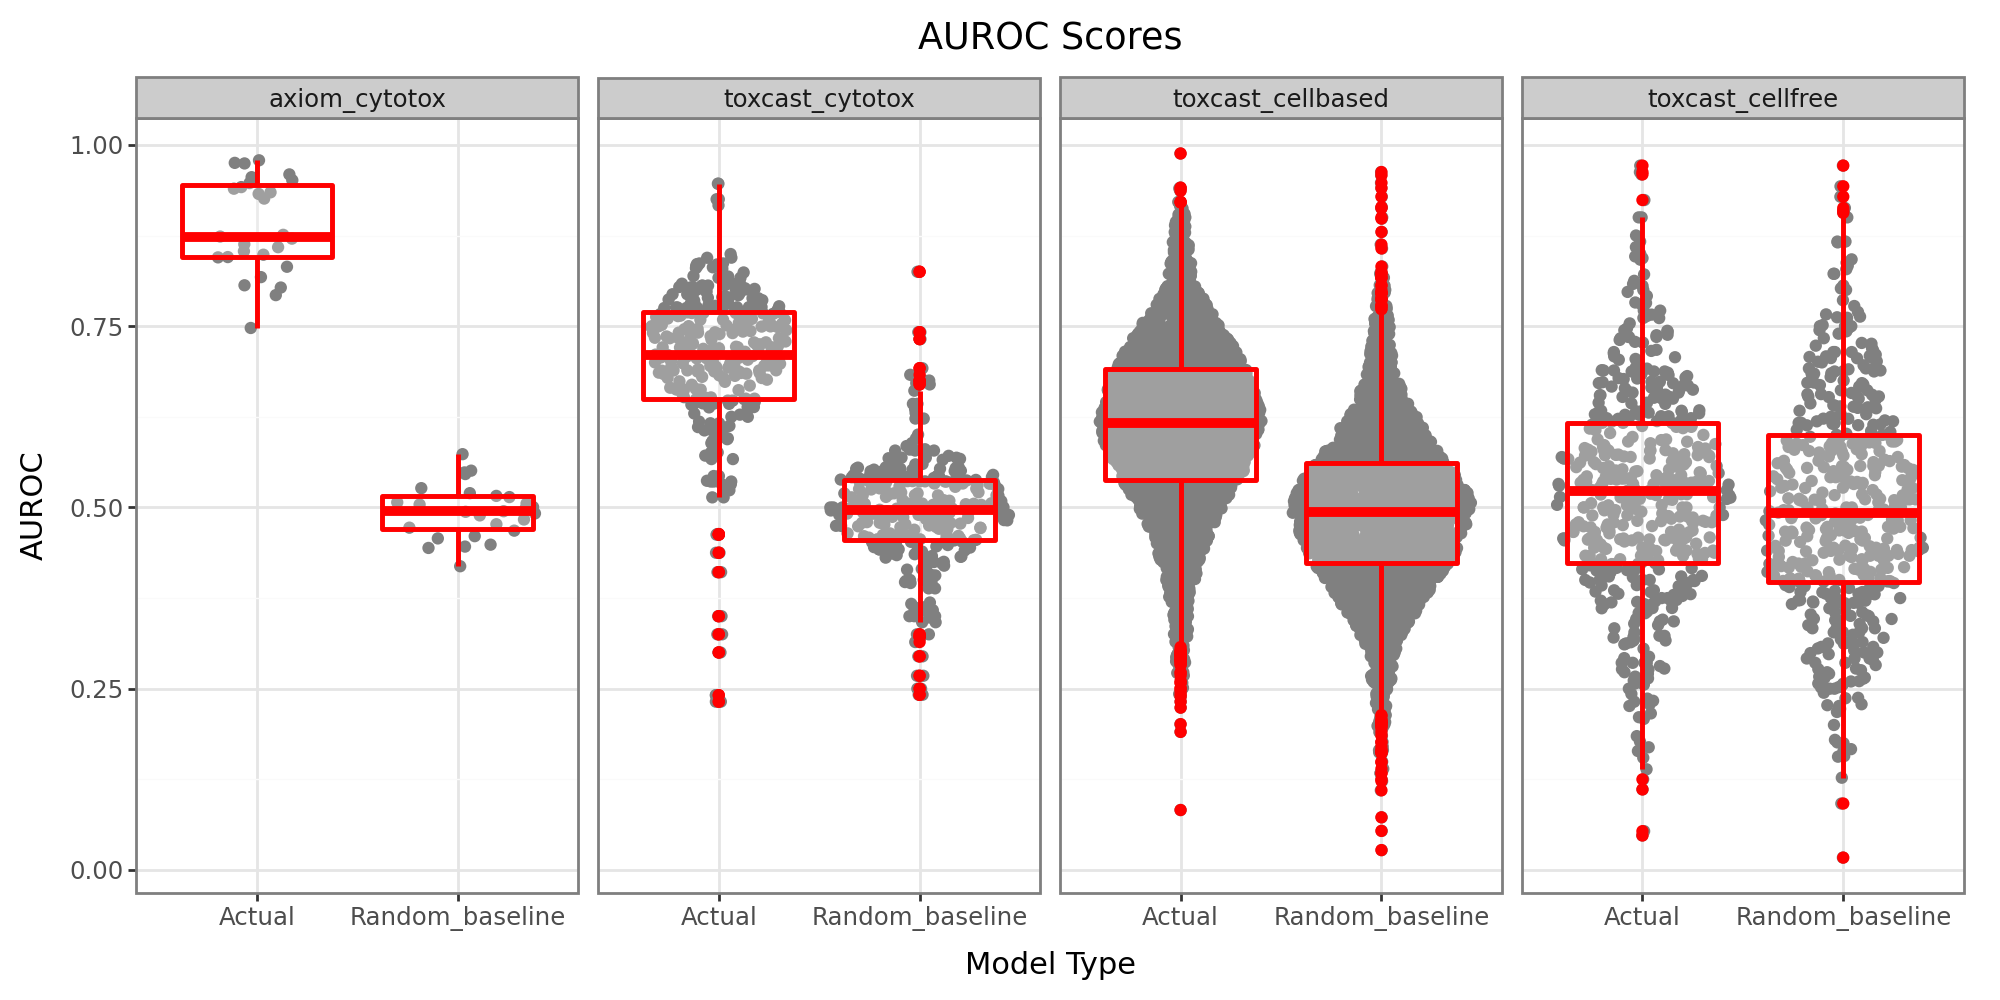

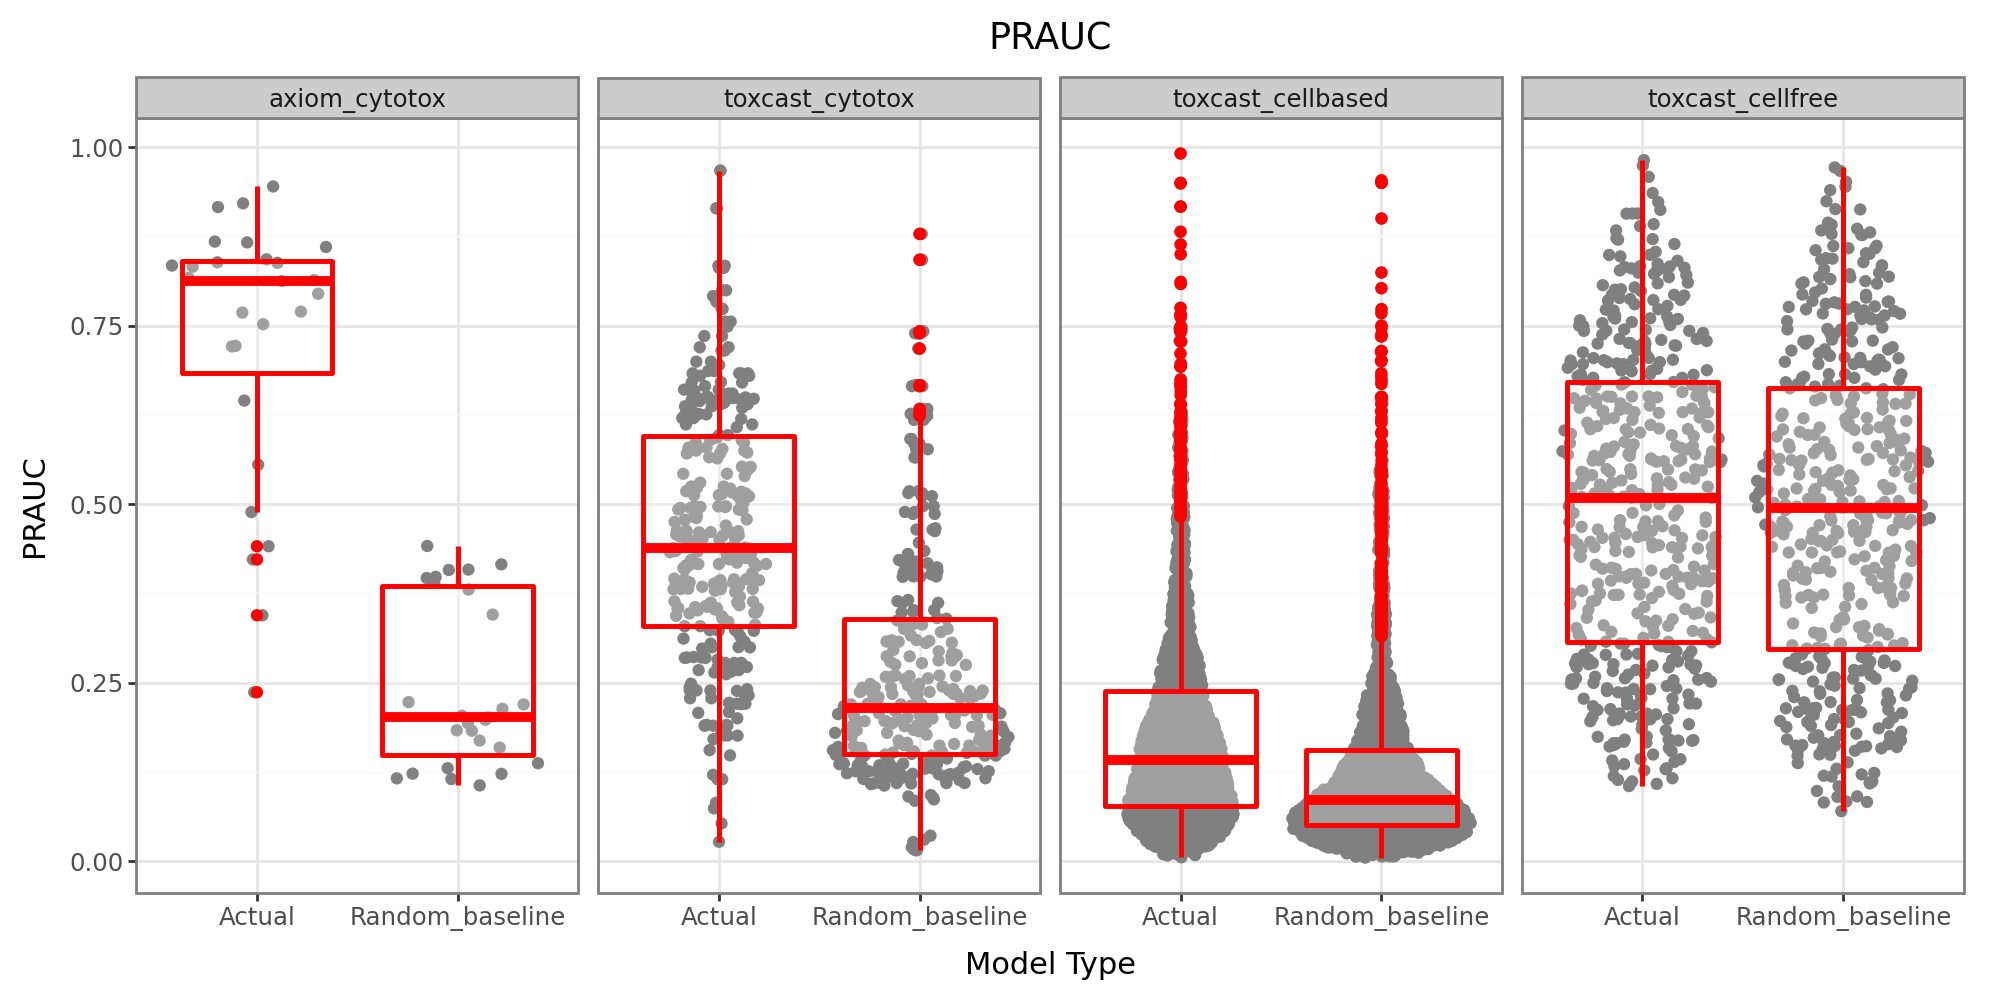

In [24]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(pred_pandas, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=5)
    + labs(title='AUROC Scores', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=5)
    + labs(title='PRAUC', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

In [ ]:
warnings.filterwarnings("ignore")

auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "AUROC ~ Model_type", 
        group_data, 
        groups=group_data["Metadata_Label"],
        re_formula="~Feat_type+Metadata_AggType"
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Model_type"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.3924   0.0 -0.4064 -0.3784   True
------------------------------------------------------------
P-values: [6.99440506e-15]
Processing Endpoint_type: toxcast_cytotox
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1      group2     meandiff p-adj lower   upper  reject
-----------------------------------------------------------
Actual Random_baseline  -0.1996   0.0 -0.206 -0.1933   True
-----------------------------------------------------------
P-values: [1.51656465e-13]
Processing Endpoint_type: toxcast_cellbased
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.1164 

In [49]:
warnings.filterwarnings("ignore")

prauc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "PRAUC ~ Model_type", 
        group_data, 
        groups=group_data["Metadata_Label"],
        re_formula="~Feat_type+Metadata_AggType"
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Model_type"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    prauc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.4847   0.0 -0.5487 -0.4208   True
------------------------------------------------------------
P-values: [6.99440506e-15]
Processing Endpoint_type: toxcast_cytotox
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1      group2     meandiff p-adj  lower  upper  reject
-----------------------------------------------------------
Actual Random_baseline  -0.1859   0.0 -0.2088 -0.163   True
-----------------------------------------------------------
P-values: [1.51656465e-13]
Processing Endpoint_type: toxcast_cellbased
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.0514 

## Cytotox: liver vs. non-liver

In [ ]:
# what are the top performing toxcast_cytotox cell lines?
cyto_df = (pred_df.filter(pl.col("Endpoint_type") == "toxcast_cytotox")
                  .filter(pl.col("Model_type") == "Actual")
                  .filter(pl.col("Total_Compounds") > 500)
                  .with_columns(
                    pl.when(pl.col("Metadata_Label").is_in(["tissue__liver", "cell_type__HepG2"])).then(pl.lit("Liver")).otherwise(pl.lit("Non-liver")).alias("Tissue_source")
                  ))
cyto_pandas = cyto_df.to_pandas()

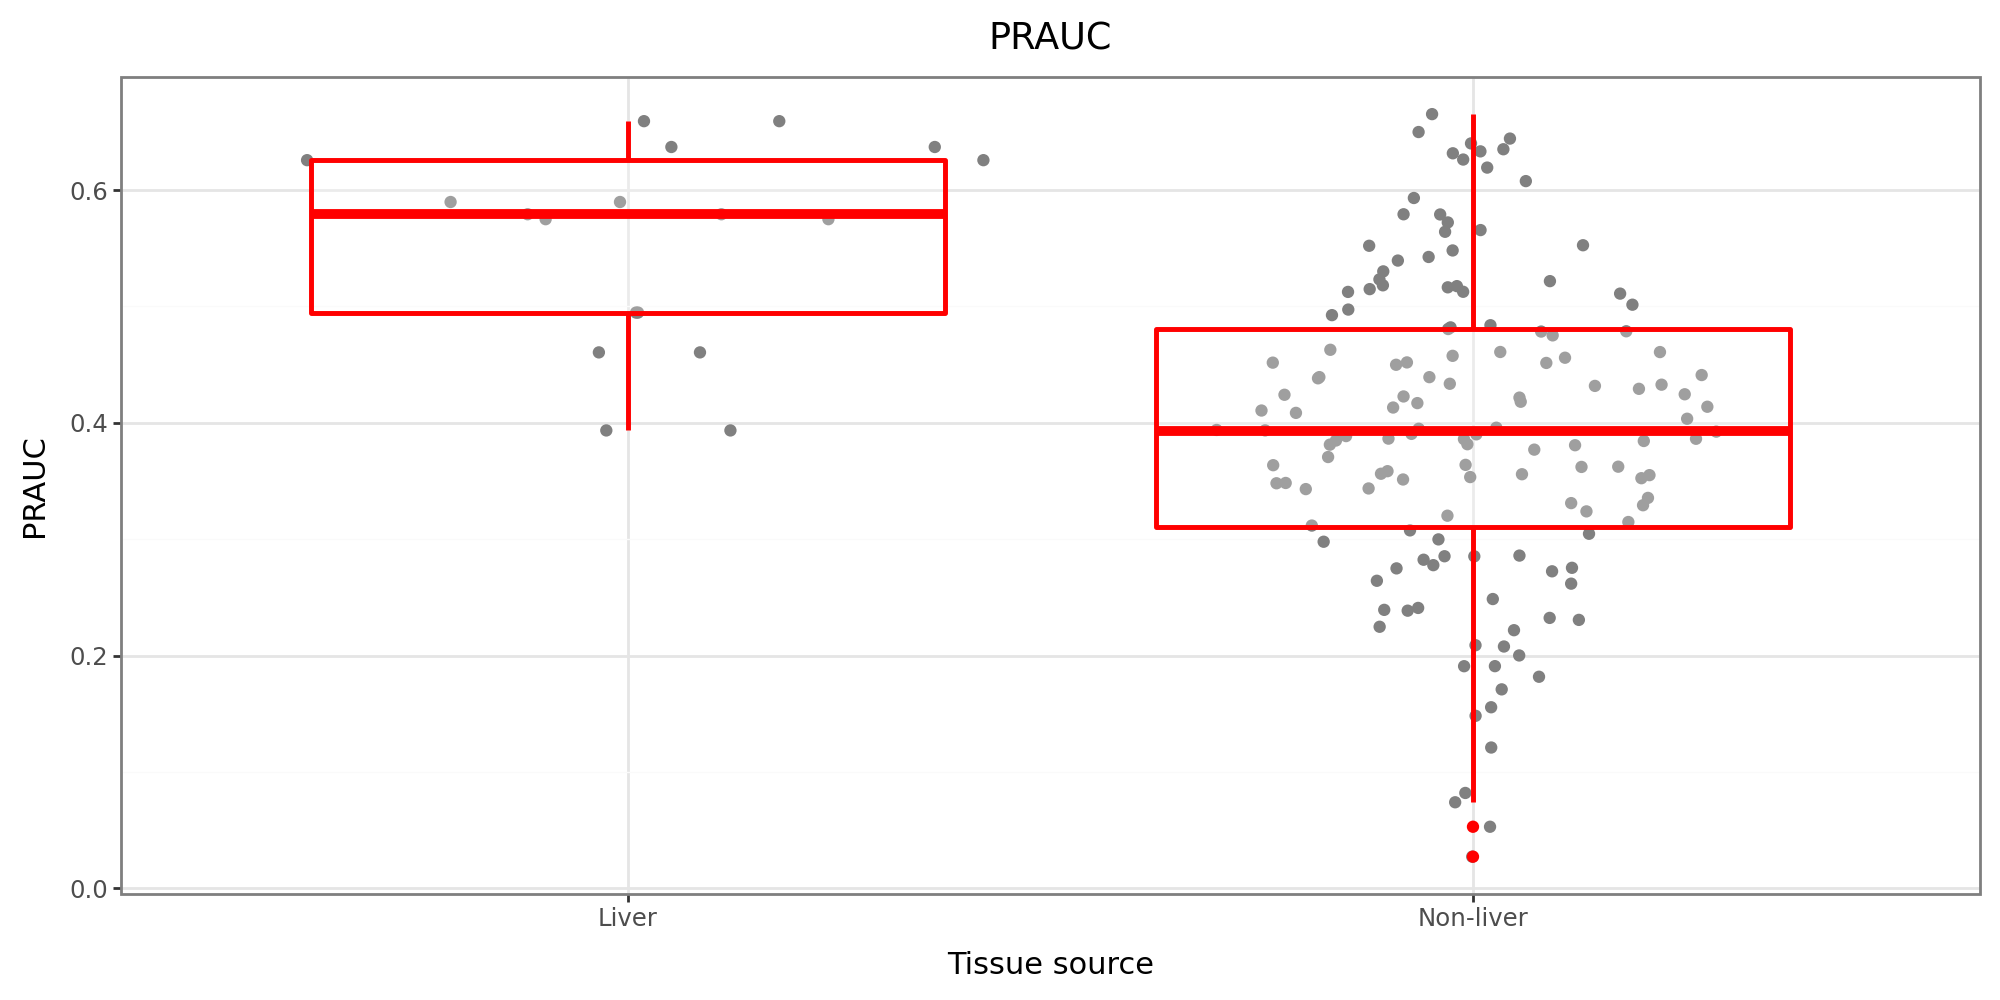

In [39]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cyto_df, aes(x='Tissue_source', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores', x='Tissue source', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cyto_df, aes(x='Tissue_source', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PRAUC', x='Tissue source', y='PRAUC') 
    + theme_bw()
)
plot.show()

In [42]:
model = smf.mixedlm("AUROC ~ Tissue_source", cyto_pandas, groups=cyto_pandas["Metadata_AggType"])
result = model.fit()
cyto_pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(cyto_pandas["fitted_values"], cyto_pandas["Tissue_source"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj  lower   upper  reject
------------------------------------------------------
 Liver Non-liver  -0.0485   0.0 -0.0649 -0.0321   True
------------------------------------------------------
[3.06433372e-08]


/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


In [43]:
model = smf.mixedlm("PRAUC ~ Tissue_source", cyto_pandas, groups=cyto_pandas["Metadata_AggType"])
result = model.fit()
cyto_pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(cyto_pandas["fitted_values"], cyto_pandas["Tissue_source"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj  lower   upper  reject
------------------------------------------------------
 Liver Non-liver  -0.1637   0.0 -0.2008 -0.1266   True
------------------------------------------------------
[0.]


/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


## Split cell-based into categories

In [54]:
cell_info = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cellbased_info.parquet").select([
    "assay_component_endpoint_name", "assay_component_desc", "tissue", "cell_short_name", 
    "intended_target_type", "intended_target_type_sub", "assay_function_type",
    "intended_target_family", "intended_target_family_sub"
]).unique()

In [67]:
cell_df = pred_df.filter(pl.col("Model_type") == "Actual").rename({"Metadata_Label": "assay_component_endpoint_name"})
cell_df = cell_info.join(cell_df, on="assay_component_endpoint_name", how="inner")
cell_df = cell_df.with_columns((pl.col("Metadata_Count_1")/pl.col("Total_Compounds")).alias("Percent_positive"))
cell_df

shape: (2_403, 19)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ assay_com ┆ assay_com ┆ tissue   ┆ cell_shor ┆ … ┆ Feat_type ┆ Total_Com ┆ Endpoint_ ┆ Percent_p │
│ ponent_en ┆ ponent_de ┆ ---      ┆ t_name    ┆   ┆ ---       ┆ pounds    ┆ type      ┆ ositive   │
│ dpoint_na ┆ sc        ┆ str      ┆ ---       ┆   ┆ str       ┆ ---       ┆ ---       ┆ ---       │
│ me        ┆ ---       ┆          ┆ str       ┆   ┆           ┆ i32       ┆ str       ┆ f64       │
│ ---       ┆ str       ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ str       ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ TOX21_HSE ┆ TOX21_HSE ┆ cervix   ┆ HeLa      ┆ … ┆ cpcnn     ┆ 587       ┆ toxcast_c ┆ 0.020443  │
│ _BLA_Agon ┆ _BLA_Agon ┆          ┆           ┆   ┆           ┆           ┆ ellbased  ┆           │
│ ist_ratio ┆ ist_ratio ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│           ┆ is…       ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ ACEA_AR_a ┆ ACEA_AR_a ┆ prostate ┆ 22Rv1     ┆ … ┆ cpcnn     ┆ 202       ┆ toxcast_c ┆ 0.064356  │
│ gonist_80 ┆ gonist_80 ┆          ┆           ┆   ┆           ┆           ┆ ellbased  ┆           │
│ hr        ┆ hr is one ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│           ┆ of…       ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ OT_ERa_GF ┆ OT_ERa_GF ┆ cervix   ┆ HeLa      ┆ … ┆ cpcnn     ┆ 202       ┆ toxcast_c ┆ 0.108911  │
│ PERaERE_0 ┆ PERaERE_0 ┆          ┆           ┆   ┆           ┆           ┆ ellbased  ┆           │
│ 480       ┆ 480 is    ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│           ┆ one o…    ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ TOX21_ERR ┆ TOX21_ERR ┆ kidney   ┆ ERR-HEK29 ┆ … ┆ cpcnn     ┆ 595       ┆ toxcast_c ┆ 0.166387  │
│ _Antagoni ┆ _Agonist  ┆          ┆ 3T        ┆   ┆           ┆           ┆ ellbased  ┆           │
│ st        ┆ is one of ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│           ┆ on…       ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ BSK_3C_MC ┆ BSK_3C_MC ┆ vascular ┆ umbilical ┆ … ┆ cpcnn     ┆ 202       ┆ toxcast_c ┆ 0.084158  │
│ P1        ┆ P1 is an  ┆          ┆ vein endo ┆   ┆           ┆           ┆ ellbased  ┆           │
│           ┆ assay     ┆          ┆ thelium   ┆   ┆           ┆           ┆           ┆           │
│           ┆ compon…   ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ …         ┆ …         ┆ …        ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ APR_HepG2 ┆ APR_HepG2 ┆ liver    ┆ HepG2     ┆ … ┆ cellprofi ┆ 164       ┆ toxcast_c ┆ 0.067073  │
│ _MitoMemb ┆ _MitoMemb ┆          ┆           ┆   ┆ ler       ┆           ┆ ellbased  ┆           │
│ Pot_24hr  ┆ Pot_24hr  ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│           ┆ is …      ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ BSK_3C_HL ┆ BSK_3C_HL ┆ vascular ┆ umbilical ┆ … ┆ cellprofi ┆ 202       ┆ toxcast_c ┆ 0.193069  │
│ ADR       ┆ ADR is an ┆          ┆ vein endo ┆   ┆ ler       ┆           ┆ ellbased  ┆           │
│           ┆ assay     ┆          ┆ thelium   ┆   ┆           ┆           ┆           ┆           │
│           ┆ compo…    ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ TOX21_ERb ┆ TOX21_ERb ┆ kidney   ┆ HEK293T   ┆ … ┆ cellprofi ┆ 595       ┆ toxcast_c ┆ 0.018487  │
│ _BLA_Agon ┆ _BLA_Agon ┆          ┆           ┆   ┆ ler       ┆           ┆ ellbased  ┆           │
│ ist_ratio ┆ ist_ratio ┆          ┆      

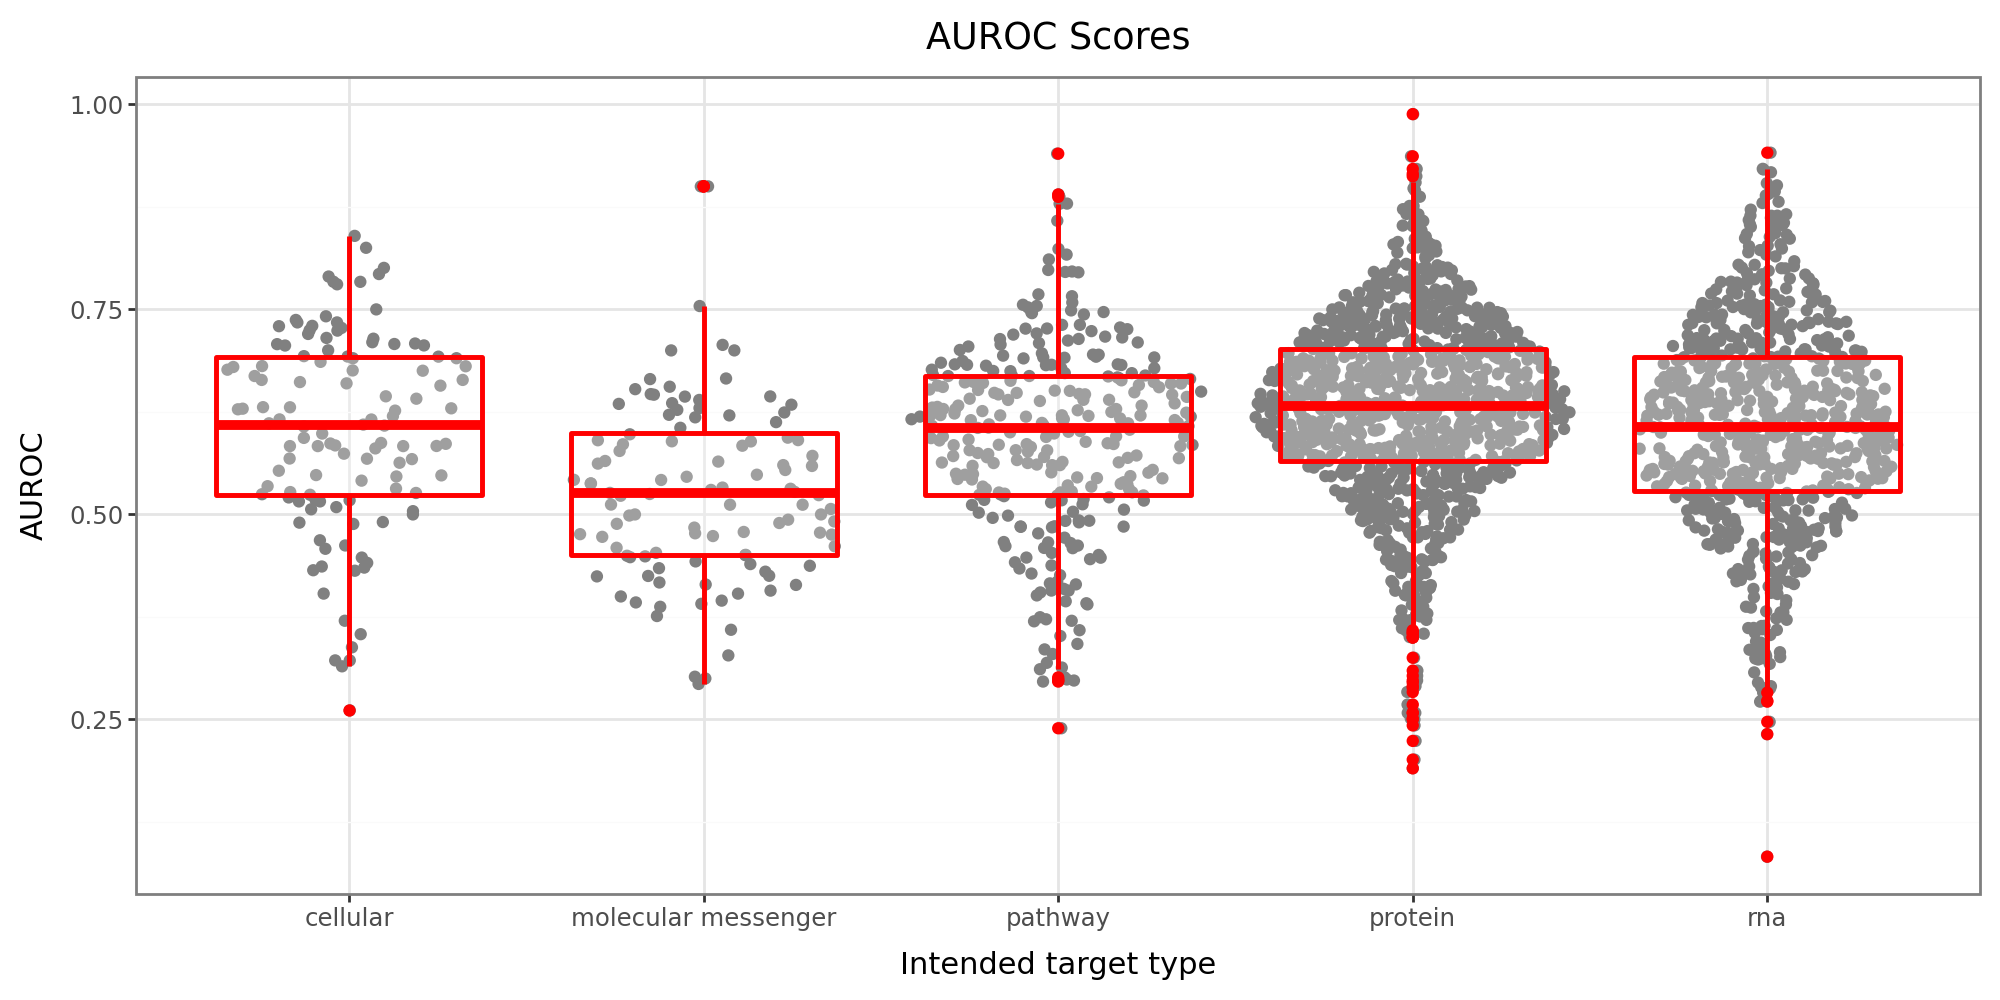

In [ ]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cell_df, aes(x='intended_target_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores', x='Intended target type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cell_df, aes(x='intended_target_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PRAUC', x='Intended target type', y='PRAUC') 
    + theme_bw()
)
plot.show()

In [ ]:
tissue_df = cell_df.filter(
    pl.col("Total_Compounds") > 100
)

from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap, theme, element_text
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(tissue_df, aes(x='tissue', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores', x='Tissue', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(tissue_df, aes(x='tissue', y='Total_Compounds')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Tested compounds per endpoint', x='Tissue', y='Compound #') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(tissue_df, aes(x='tissue', y='Percent_positive')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Percent_positive', x='Percent_positive', y='Compound #') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

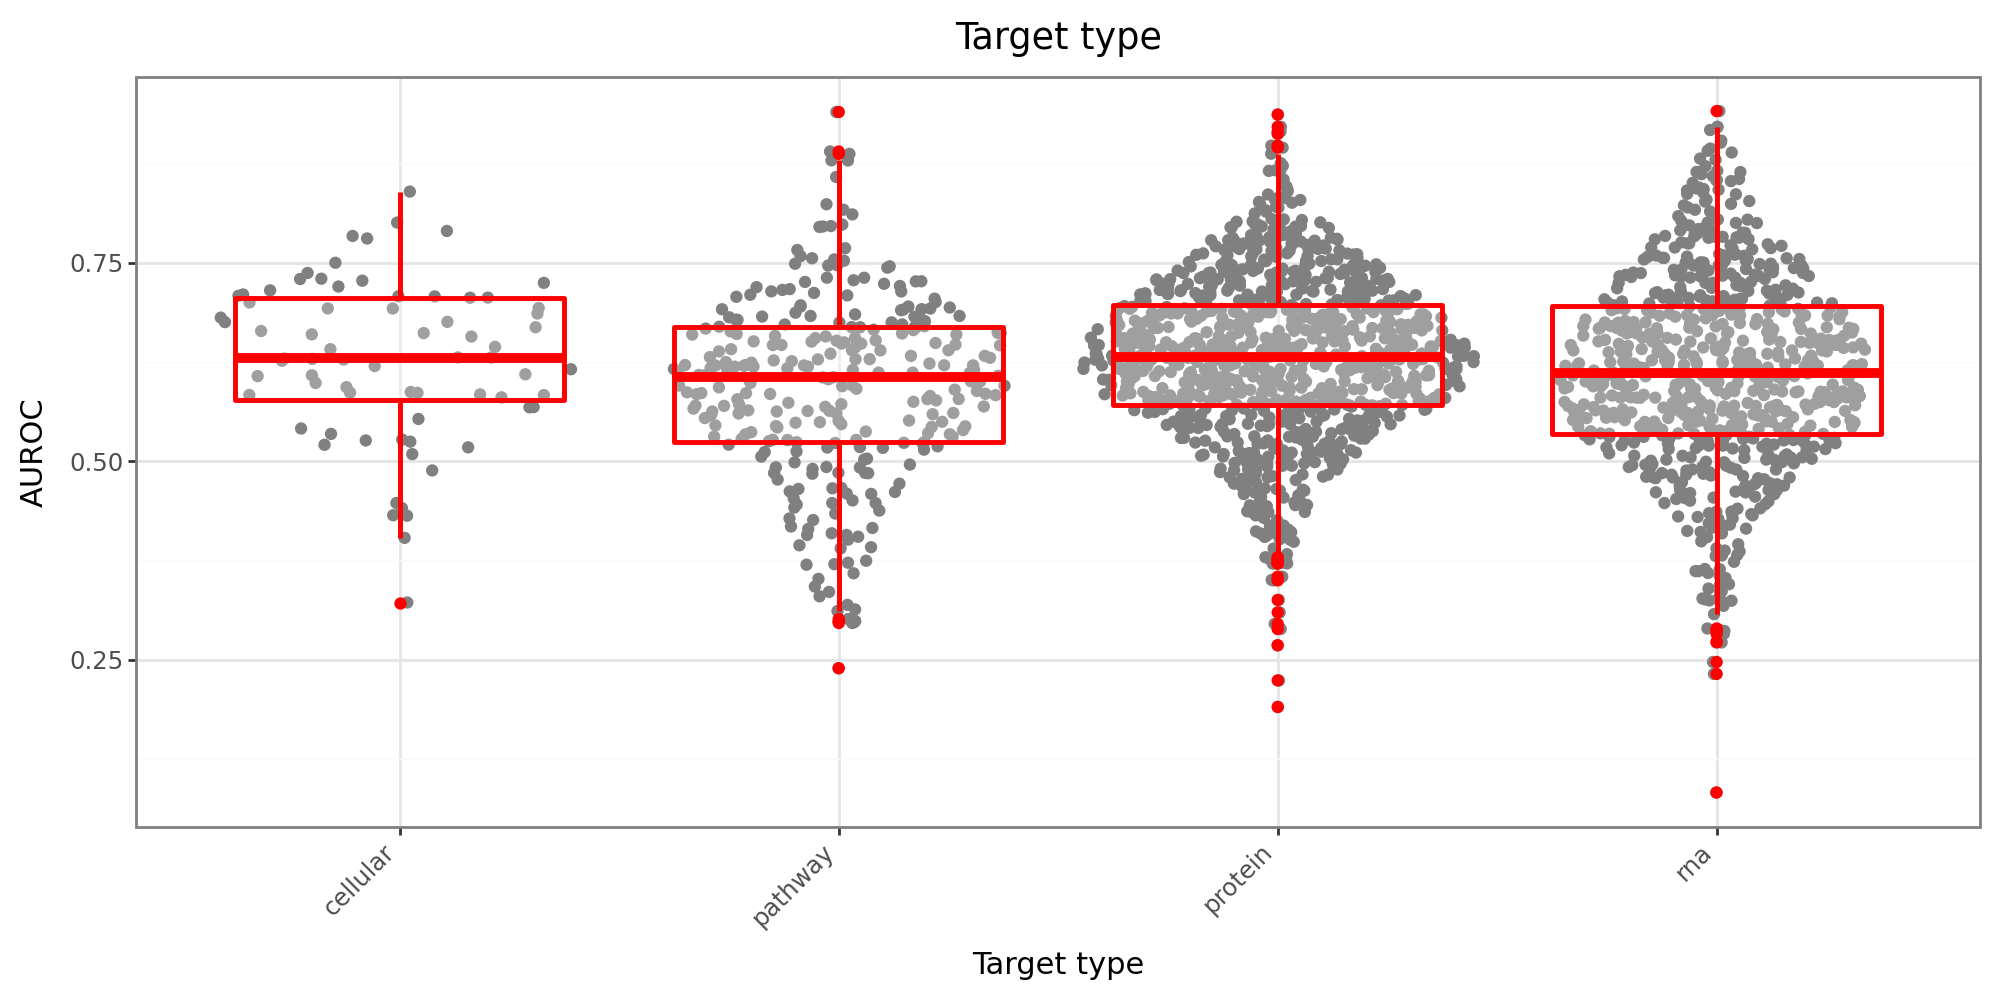

In [71]:
plot = (
    ggplot(tissue_df, aes(x='intended_target_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target type', x='Target type', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()


plot = (
    ggplot(tissue_df, aes(x='intended_target_type_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target type (sub)', x='Target type (sub)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()


plot = (
    ggplot(tissue_df, aes(x='intended_target_family', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family', x='Target family', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(tissue_df, aes(x='assay_function_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Assay function', x='Assay function', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

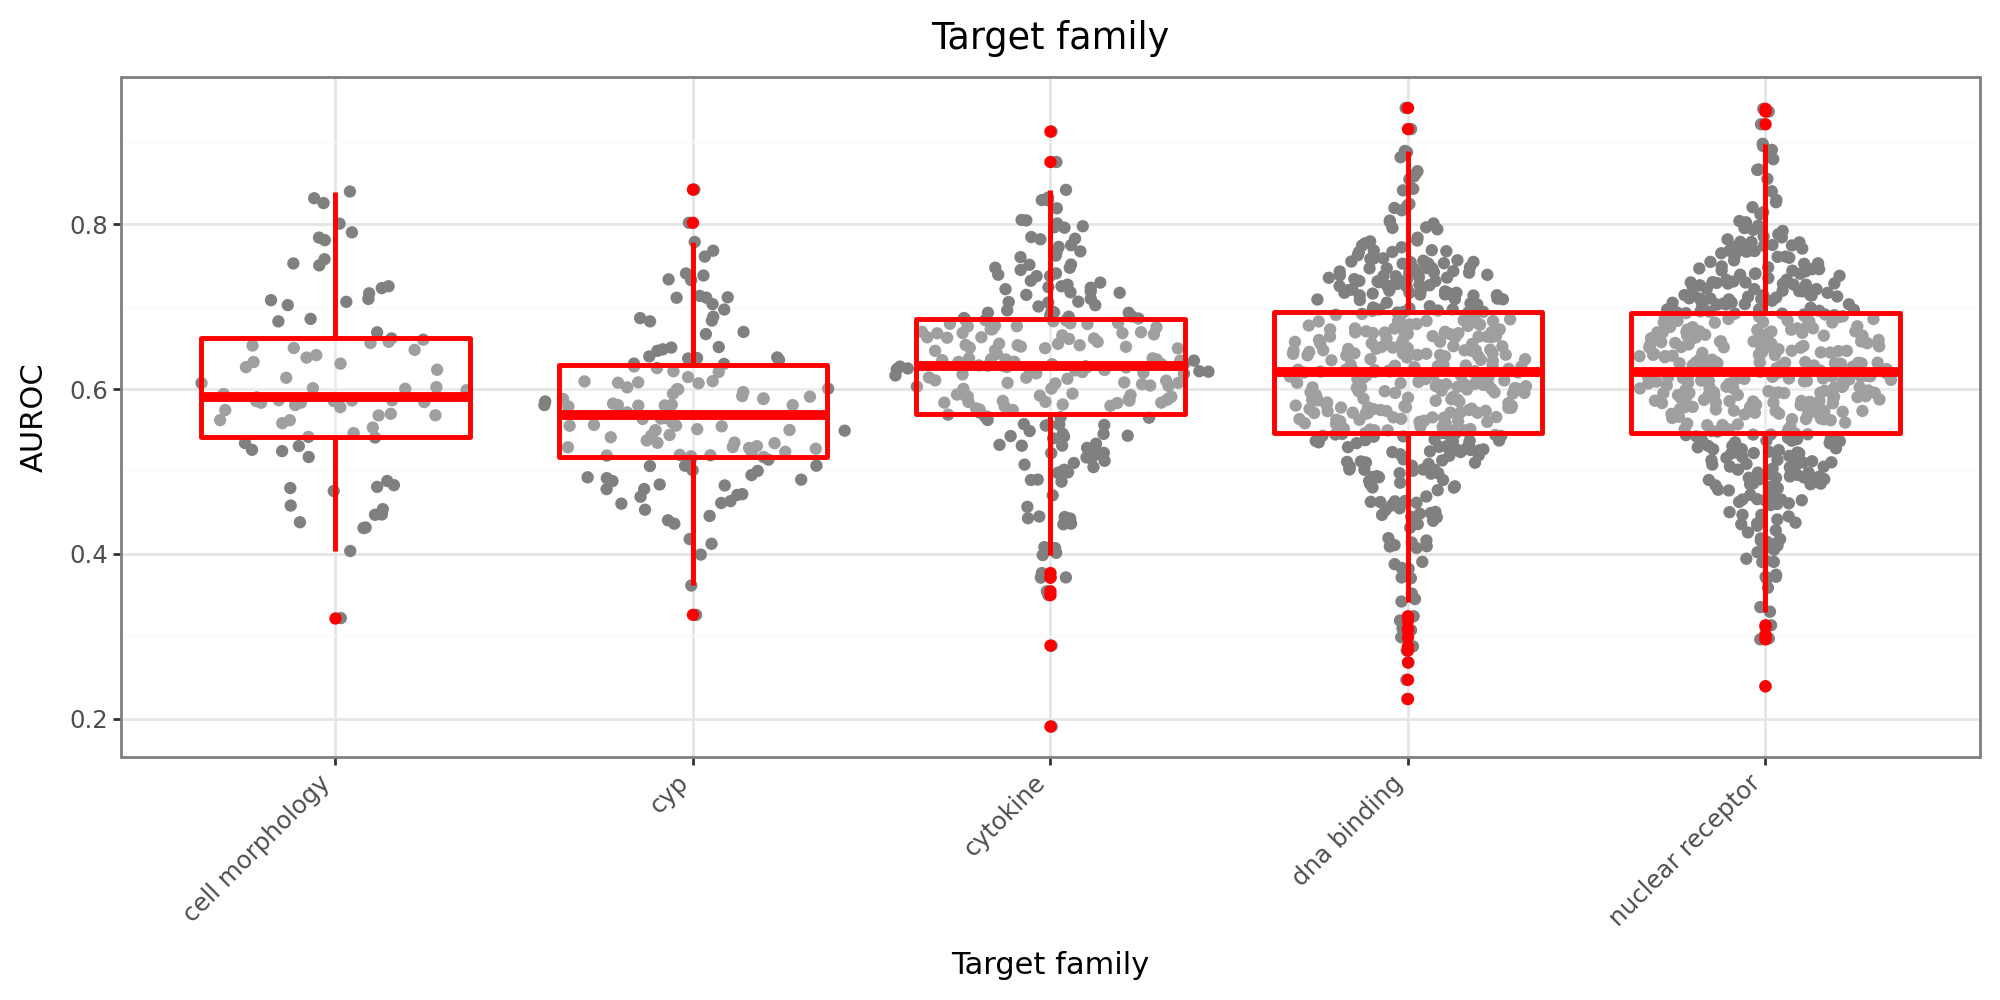

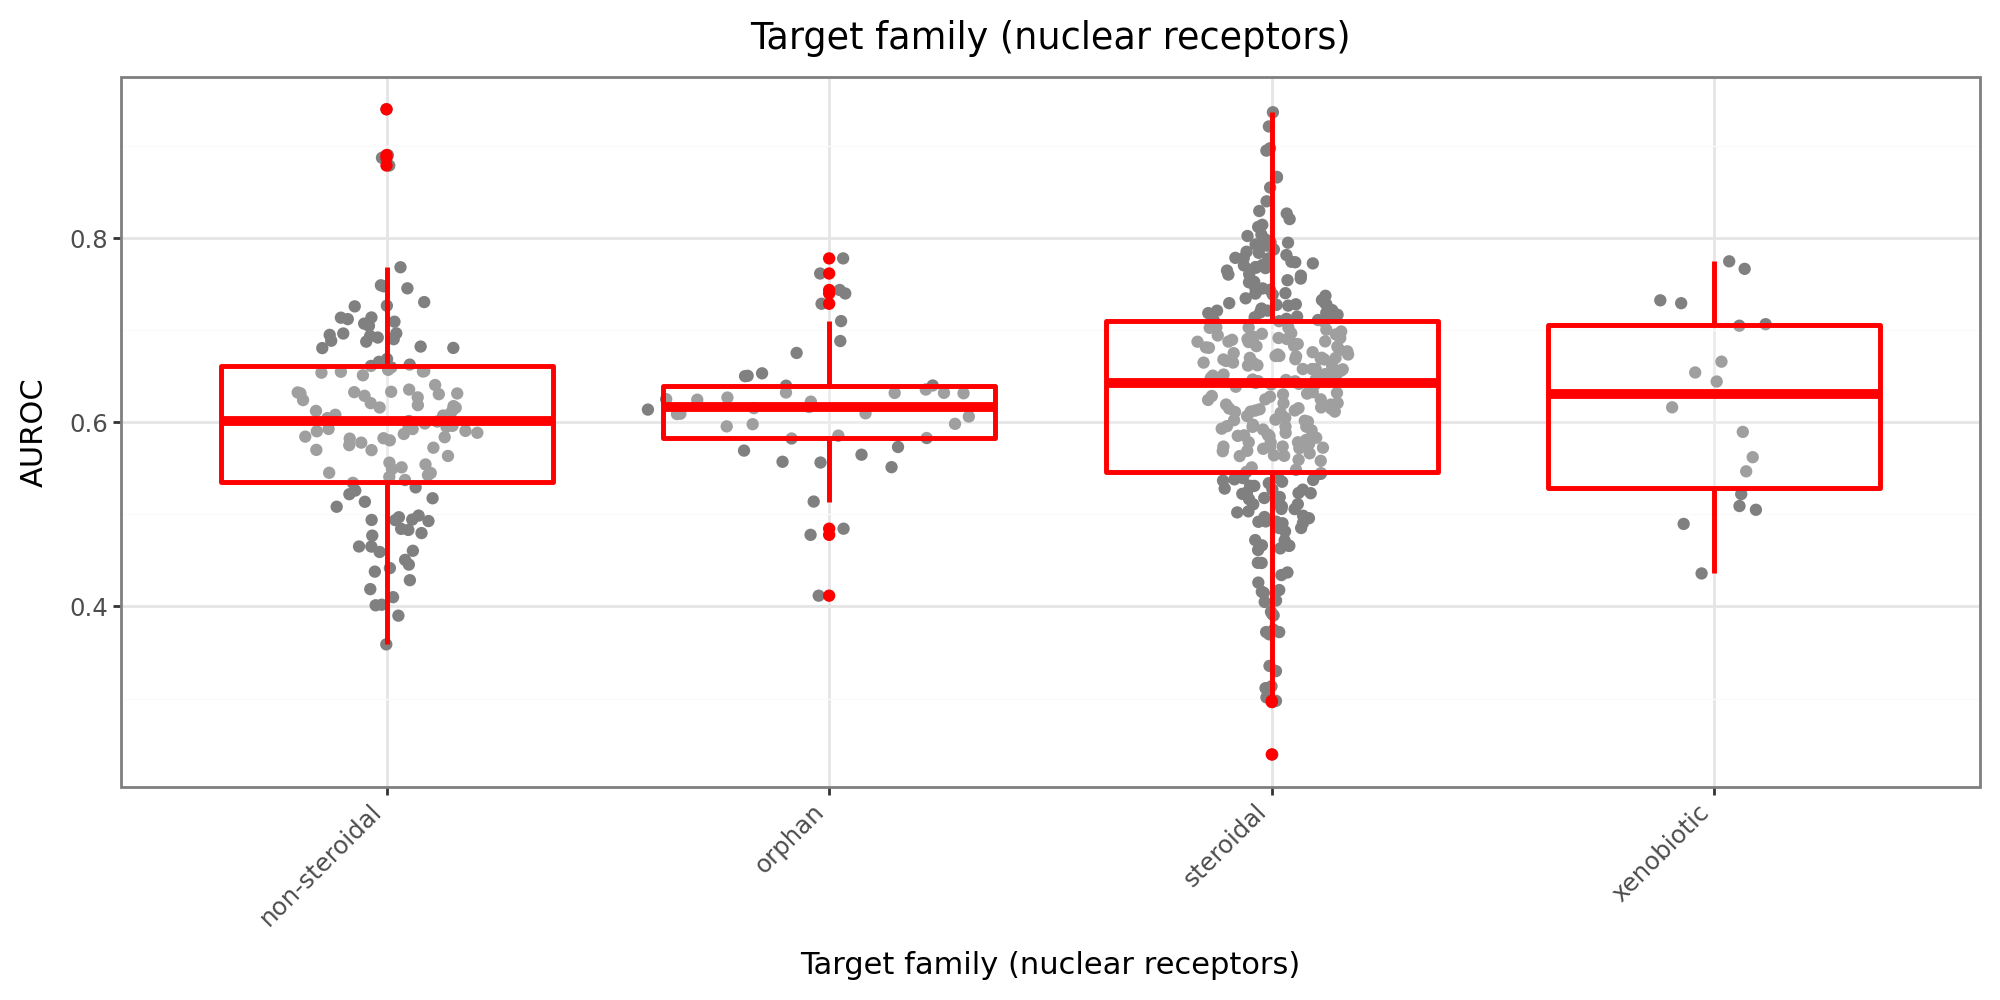

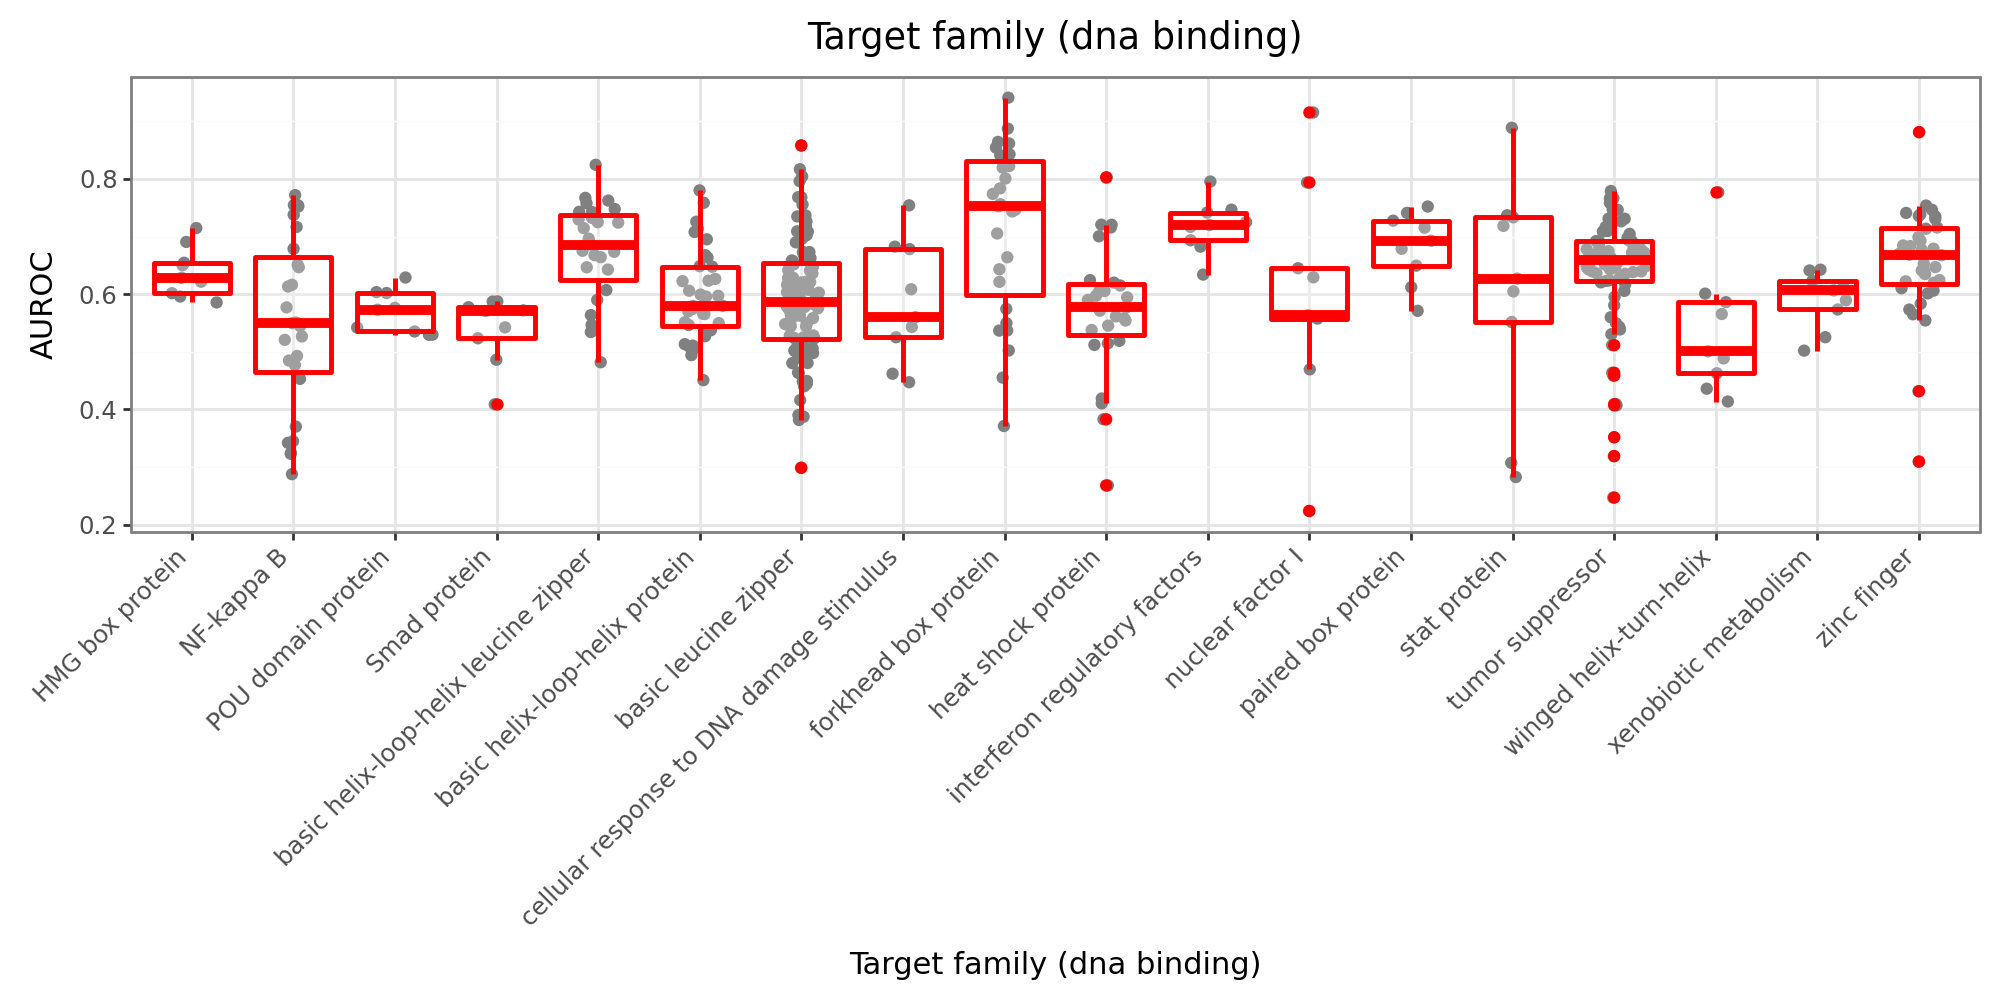

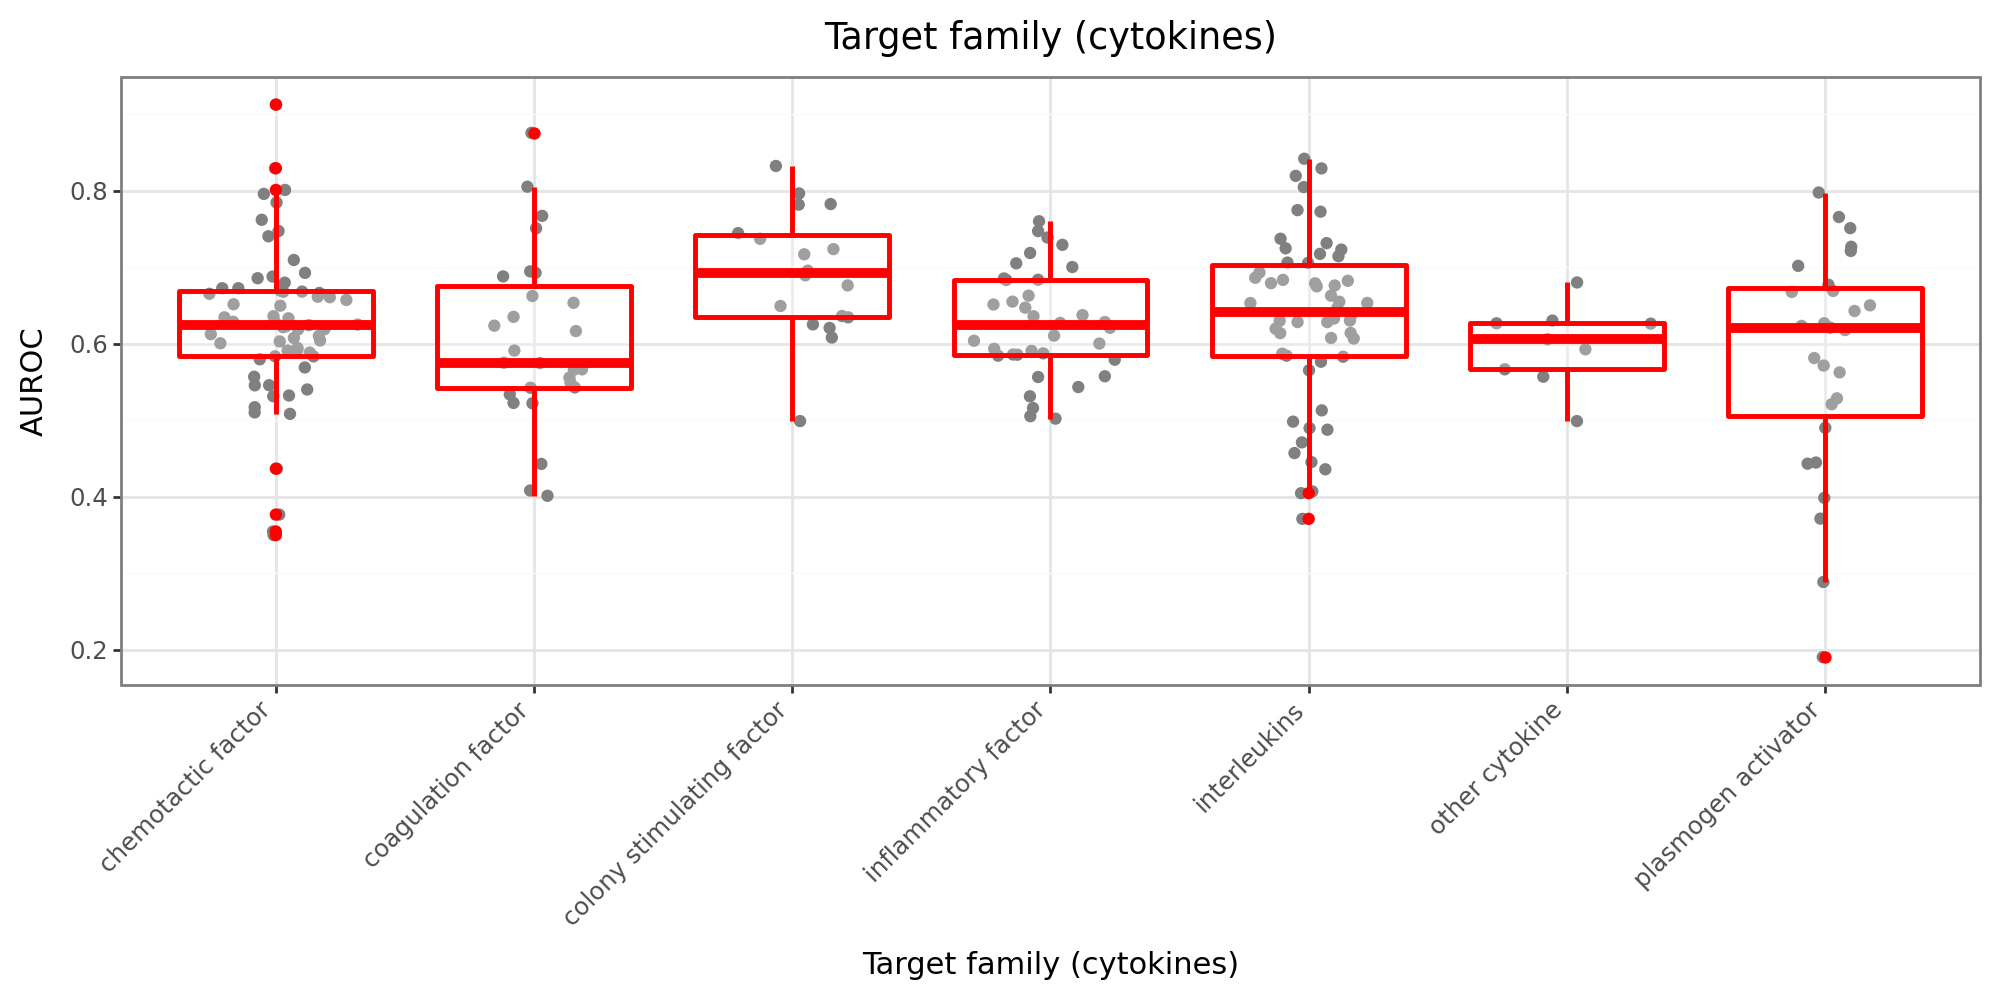

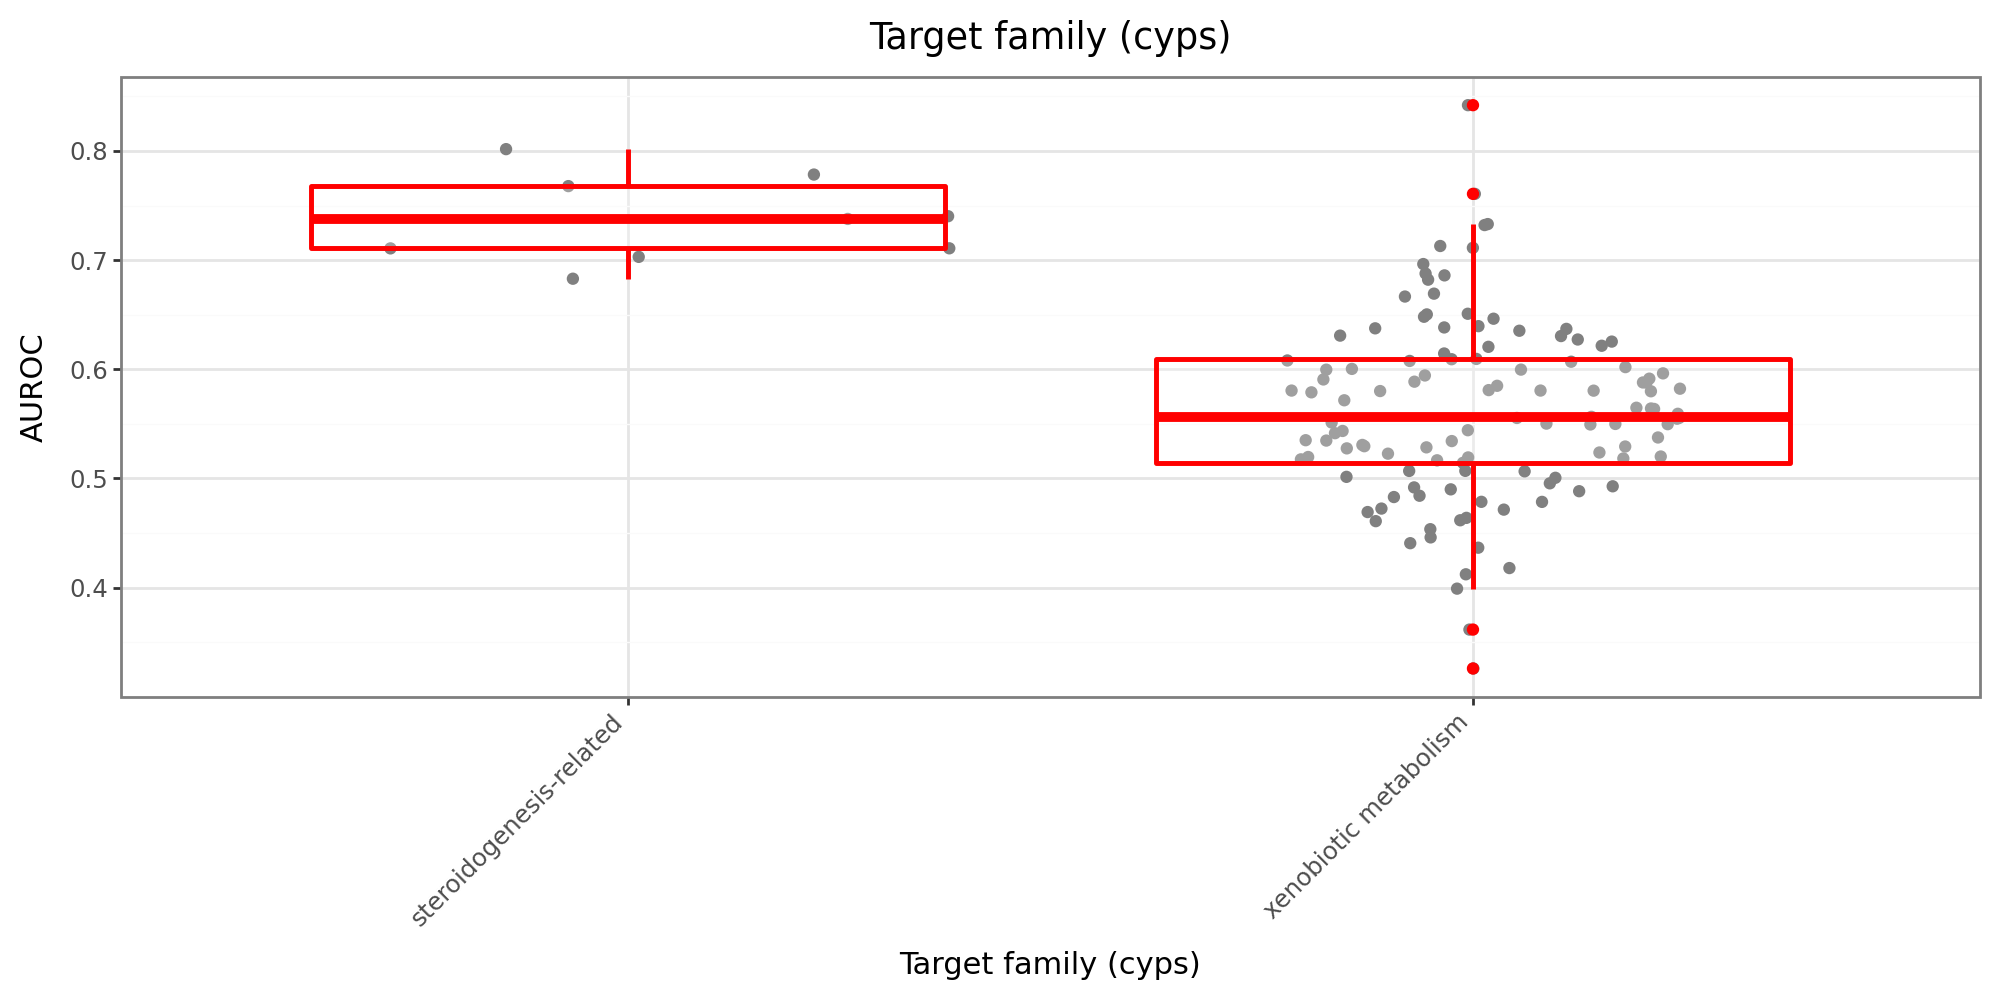

In [77]:
family_df = tissue_df.filter(
    pl.col("intended_target_family").is_in([
        "nuclear receptor",
        "dna binding",
        "cytokine",
        "cyp",
        "cell morphology"
    ])
)

plot = (
    ggplot(family_df, aes(x='intended_target_family', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family', x='Target family', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "nuclear receptor"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (nuclear receptors)', x='Target family (nuclear receptors)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "dna binding"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (dna binding)', x='Target family (dna binding)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "cytokine"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (cytokines)', x='Target family (cytokines)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "cyp"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (cyps)', x='Target family (cyps)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "cell morphology"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (cell morphology)', x='Target family (cell morphology)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()
